
## <font face="Avenir" size=4>1. Imports and setup<font>

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

from google.auth import default
from google.colab import auth
from google.colab import drive
from google.colab import output
drive.mount('/content/drive')

# %pip install --upgrade -q gspread
# import gspread
# auth.authenticate_user()
# creds, _ = default()
# gc = gspread.authorize(creds)

%cd /content/drive/MyDrive/irt2024_saves

Mounted at /content/drive
/content/drive/MyDrive/irt2024_saves


In [2]:
%cp -r ./ml_data_0508.zip /content/
!unzip /content/ml_data_0508.zip -d /content/
output.clear()

In [3]:
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np

seed = 123
np.random.seed(seed)

dataset_dir = '/content/ml_data'

from matplotlib.colors import LinearSegmentedColormap
colors = plt.imread('./style/grey.png')
cmap = LinearSegmentedColormap.from_list('thermal', colors[10, :, :3])
plt.style.use('./style/style.mplstyle')

font_dir = './style/Avenir'
for font in fm.findSystemFonts(font_dir):
    fm.fontManager.addfont(font)
mpl.rcParams['font.family'] = 'Avenir'

In [4]:
import os

import cv2
import numpy as np
import pandas as pd
from scipy.constants import convert_temperature as conv_temp

In [5]:
from resunet import ResUNet
from unet import UNet

def get_model_size(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

get_model_size(ResUNet()), get_model_size(UNet(ch_mult=8))


(182554, 269658)

## <font face="Avenir" size=4>2. Ablation study<font>

### <font face="Avenir" size=3>2.1 CNN Ablation: Architectures<font>

In [ ]:
def get_corr_mae(df):
    est = df['est_base_forehead'].to_numpy().copy()
    est_classifier = df['est_base_forehead'].to_numpy().copy()
    gt = df['gt_base_forehead'].to_numpy()

    mask = df['est_label'] == 1
    est_classifier[mask] = gt[mask]
    return np.abs(est - gt).mean(), np.abs(est_classifier - gt).mean()

all_errors = []
folds = [0, 1, 2, 3, 4]
for fold_num in folds:
    df = pd.read_csv(f'./saves/classifier/{fold_num}.csv')
    cool_df = df[df['fname'].str.contains('_cool_')]
    base_df = df[df['fname'].str.contains('_base_')]
    fever_df = df[df['fname'].str.contains('_fever_')]

    errors = []
    for session_df in [base_df, cool_df, fever_df]:
        errors += [get_corr_mae(session_df)]
    errors += [np.mean(errors[:2], axis=0), np.mean(errors, axis=0)]
    all_errors += [errors]
all_errors = np.array(all_errors)

In [ ]:
mean = all_errors.mean(axis=0)
std = all_errors.std(axis=0)

no_classifier = []
classifier = []

for i in range(mean.shape[0]):
    m1, m2 = mean[i]
    std1, std2 = std[i]
    no_classifier.append(f'{m1:.3f} $\pm$ {std1:.3f}')
    classifier.append(f'{m2:.3f} $\pm$ {std2:.3f}')

In [ ]:
' & '.join(no_classifier)

'0.241 $\\pm$ 0.063 & 0.735 $\\pm$ 0.124 & 0.470 $\\pm$ 0.154 & 0.488 $\\pm$ 0.079 & 0.482 $\\pm$ 0.099'

In [ ]:
' & '.join(classifier)

'0.100 $\\pm$ 0.038 & 0.696 $\\pm$ 0.097 & 0.197 $\\pm$ 0.094 & 0.398 $\\pm$ 0.051 & 0.331 $\\pm$ 0.060'

In [ ]:
# model results

expt_folders = ['sl1_unet', 'sl1_unet_instance', 'sl1_resunet_batchnorm', 'sl1_resunet_instance_FULL', 'sl1_resunet']
expt_names = ['UNet BN', 'UNet IN', 'ResUNet BN', 'ResUNet IN', 'ResUNet IN + BN (skip)']
sessions = ['base', 'cool', 'fever', 'cool_base', 'cool_base_fever']
columns = ['expt_name', 'fold'] + sessions

folds = [0, 1, 2, 3, 4]
losses = []
for expt_dir, expt_name in zip(expt_folders, expt_names):
    for fold in folds:
        df = pd.read_csv(f'./saves/{expt_dir}/fold_{fold}/forehead_val_losses.csv')
        df['cool_base'] = (df['cool'] + df['base']) / 2
        df['cool_base_fever'] = (df['cool'] + df['base'] + df['fever']) / 3
        row = [expt_name, fold] + list(df.iloc[0][sessions])
        losses += [row]

full_df = pd.DataFrame(data=losses, columns=columns)

mean_df = full_df.groupby(['expt_name'], sort=False)[sessions].mean().add_suffix('_mean')
std_df = full_df.groupby(['expt_name'], sort=False)[sessions].std().add_suffix('_std')
full_df = pd.concat([mean_df, std_df], axis=1)

disp_df = pd.DataFrame()
for s in sessions:
    func = lambda x: f'{x[s + "_mean"]:.3f} $\pm$ {x[s + "_std"]:.3f}'
    disp_df[s] = full_df.apply(func, axis=1)

disp_df.to_csv('./saves/ablation_architectures.csv')
disp_df

,base,cool,fever,cool_base,cool_base_fever
expt_name,,,,,
UNet BN,0.156 $\pm$ 0.043,0.842 $\pm$ 0.147,0.282 $\pm$ 0.039,0.499 $\pm$ 0.080,0.427 $\pm$ 0.059
UNet IN,0.421 $\pm$ 0.146,0.775 $\pm$ 0.143,0.564 $\pm$ 0.263,0.598 $\pm$ 0.118,0.587 $\pm$ 0.133
ResUNet BN,0.274 $\pm$ 0.113,0.859 $\pm$ 0.161,0.344 $\pm$ 0.225,0.567 $\pm$ 0.107,0.493 $\pm$ 0.144
ResUNet IN,0.182 $\pm$ 0.080,0.819 $\pm$ 0.194,0.371 $\pm$ 0.185,0.500 $\pm$ 0.129,0.457 $\pm$ 0.139
ResUNet IN + BN (skip),0.241 $\pm$ 0.083,0.730 $\pm$ 0.132,0.469 $\pm$ 0.190,0.485 $\pm$ 0.090,0.480 $\pm$ 0.118


### <font face="Avenir" size=3>2.2 CNN Ablation: Loss weighting<font>

In [ ]:
# L_lpips + L_base_recon + L_full_recon
# lpips, mae_temp, class_weight
'resunet_mae' # 0, 1, 1
'resunet_mae_base' # 0.5, 0.5, 1
'resunet_lpips' # 2, 1, 1
'sl1_unet' # 1, 1, 1
'sl2_resunet' # 1, 1, 1.5
'sl3_resunet' # 1, 1, 2

In [ ]:
expt_folders = ['resunet_mae', 'resunet_mae_base', 'resunet_lpips', 'sl1_resunet', 'sl2_resunet', 'sl3_resunet']
expt_names = ['MAE only', 'MAE base high', 'LPIPS high', 'Equal', 'SL weight 1.5', 'SL weight 2']
expt_settings = [(0, 1, 1), (0.5, 0.5, 1), (2, 1, 1), (1, 1, 1), (1, 1, 1.5), (1, 1, 2)]
sessions = ['base', 'cool', 'fever', 'cool_base', 'cool_base_fever']
columns = ['expt_name', 'fold'] + sessions

settings_df = pd.DataFrame(data=expt_settings, columns=['LPIPS', 'MAE temp', 'SL weight'])
settings_df['MAE base'] = 1.0
settings_df.index = expt_names
settings_df.index.name = 'expt_name'
settings_df = settings_df[['MAE base', 'MAE temp', 'LPIPS', 'SL weight']]

folds = [0, 1, 2, 3, 4]
losses = []
for expt_dir, expt_name in zip(expt_folders, expt_names):
    for fold in folds:
        df = pd.read_csv(f'./saves/{expt_dir}/fold_{fold}/forehead_val_losses.csv')
        df['cool_base'] = (df['cool'] + df['base']) / 2
        df['cool_base_fever'] = (df['cool'] + df['base'] + df['fever']) / 3
        row = [expt_name, fold] + list(df.iloc[0][sessions])
        losses += [row]

full_df = pd.DataFrame(data=losses, columns=columns)

mean_df = full_df.groupby(['expt_name'], sort=False)[sessions].mean().add_suffix('_mean')
std_df = full_df.groupby(['expt_name'], sort=False)[sessions].std().add_suffix('_std')
full_df = pd.concat([mean_df, std_df], axis=1)

disp_df = pd.DataFrame()
for s in sessions:
    func = lambda x: f'{x[s + "_mean"]:.3f} $\pm$ {x[s + "_std"]:.3f}'  # $\pm$ ±
    disp_df[s] = full_df.apply(func, axis=1)

disp_df = pd.concat([settings_df, disp_df], axis=1)
disp_df.to_csv('./saves/ablation_loss_weights.csv', index=False)

### <font face="Avenir" size=3>2.3 CNN Ablation: Fever Augmentation<font>

In [ ]:
expt_folders = ['resunet_f0', 'resunet_f25', 'sl1_resunet', 'resunet_f75', 'resunet_f100']
expt_names = ['0', '25', '50', '75', '100']
sessions = ['base', 'cool', 'fever', 'cool_base', 'cool_base_fever']
columns = ['expt_name', 'fold'] + sessions

folds = [0, 1, 2, 3, 4]
losses = []
for expt_dir, expt_name in zip(expt_folders, expt_names):
    for fold in folds:
        df = pd.read_csv(f'./saves/{expt_dir}/fold_{fold}/forehead_val_losses.csv')
        df['cool_base'] = (df['cool'] + df['base']) / 2
        df['cool_base_fever'] = (df['cool'] + df['base'] + df['fever']) / 3
        row = [expt_name, fold] + list(df.iloc[0][sessions])
        losses += [row]

full_df = pd.DataFrame(data=losses, columns=columns)

mean_df = full_df.groupby(['expt_name'], sort=False)[sessions].mean().add_suffix('_mean')
std_df = full_df.groupby(['expt_name'], sort=False)[sessions].std().add_suffix('_std')
full_df = pd.concat([mean_df, std_df], axis=1)

disp_df = pd.DataFrame()
for s in sessions:
    func = lambda x: f'{x[s + "_mean"]:.3f} $\pm$ {x[s + "_std"]:.3f}'
    disp_df[s] = full_df.apply(func, axis=1)

disp_df.to_csv('./saves/ablation_fever_augmentation.csv')
disp_df

,base,cool,fever,cool_base,cool_base_fever
expt_name,,,,,
0,0.374 $\pm$ 0.063,0.719 $\pm$ 0.205,0.353 $\pm$ 0.077,0.546 $\pm$ 0.098,0.482 $\pm$ 0.078
25,0.357 $\pm$ 0.068,0.712 $\pm$ 0.117,0.392 $\pm$ 0.121,0.535 $\pm$ 0.086,0.487 $\pm$ 0.079
50,0.241 $\pm$ 0.083,0.730 $\pm$ 0.132,0.469 $\pm$ 0.190,0.485 $\pm$ 0.090,0.480 $\pm$ 0.118
75,0.391 $\pm$ 0.145,0.771 $\pm$ 0.152,0.571 $\pm$ 0.225,0.581 $\pm$ 0.129,0.578 $\pm$ 0.157
100,0.360 $\pm$ 0.045,0.689 $\pm$ 0.176,0.384 $\pm$ 0.161,0.524 $\pm$ 0.083,0.478 $\pm$ 0.106


In [ ]:
# FOR THE MLP MODEL

expt_folders = ['fever0', 'fever25', 'fever50', 'fever75', 'fever100']
expt_names = ['0', '25', '50', '75', '100']
sessions = ['base', 'cool', 'fever', 'cool_base', 'cool_base_fever']
columns = ['expt_name', 'fold'] + sessions

folds = [0, 1, 2, 3, 4]
losses = []
for expt_dir, expt_name in zip(expt_folders, expt_names):
    for fold in folds:
        df = pd.read_csv(f'./mlp_saves/{expt_dir}/fold_{fold}/forehead_val_losses.csv')
        df['cool_base'] = (df['cool'] + df['base']) / 2
        df['cool_base_fever'] = (df['cool'] + df['base'] + df['fever']) / 3
        row = [expt_name, fold] + list(df.iloc[0][sessions])
        losses += [row]

full_df = pd.DataFrame(data=losses, columns=columns)

mean_df = full_df.groupby(['expt_name'], sort=False)[sessions].mean().add_suffix('_mean')
std_df = full_df.groupby(['expt_name'], sort=False)[sessions].std().add_suffix('_std')
full_df = pd.concat([mean_df, std_df], axis=1)

disp_df = pd.DataFrame()
for s in sessions:
    func = lambda x: f'{x[s + "_mean"]:.3f} $\pm$ {x[s + "_std"]:.3f}'
    disp_df[s] = full_df.apply(func, axis=1)

# disp_df.to_csv('./saves/ablation_fever_augmentation_MLP.csv')
disp_df

,base,cool,fever,cool_base,cool_base_fever
expt_name,,,,,
0,0.558 $\pm$ 0.101,0.883 $\pm$ 0.110,2.133 $\pm$ 0.205,0.720 $\pm$ 0.095,1.191 $\pm$ 0.083
25,0.593 $\pm$ 0.090,0.891 $\pm$ 0.085,1.894 $\pm$ 0.154,0.742 $\pm$ 0.075,1.126 $\pm$ 0.086
50,0.585 $\pm$ 0.110,0.865 $\pm$ 0.084,1.664 $\pm$ 0.155,0.725 $\pm$ 0.094,1.038 $\pm$ 0.101
75,0.684 $\pm$ 0.104,0.911 $\pm$ 0.093,1.344 $\pm$ 0.196,0.797 $\pm$ 0.075,0.980 $\pm$ 0.082
100,0.871 $\pm$ 0.172,0.920 $\pm$ 0.092,1.299 $\pm$ 0.146,0.895 $\pm$ 0.109,1.030 $\pm$ 0.080


## <font face="Avenir" size=4>3. Final model results<font>

In [6]:
from scipy.stats import pearsonr, spearmanr, kendalltau, wilcoxon
from sklearn.metrics import confusion_matrix


def mae_fn(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mse_fn(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def rmse_fn(y_true, y_pred):
    return np.sqrt(mse_fn(y_true, y_pred))

def mape_fn(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def correlation_fn(y_true, y_pred):
    return pearsonr(gt, est).statistic

def specificity_fn(y_true, y_pred):
    class_true = y_true > 35.35
    class_pred = y_pred > 35.35
    tn, fp, fn, tp = confusion_matrix(class_true, class_pred).ravel()
    val = tn / (tn+fp)
    return val

def accuracy_fn(y_true, y_pred):
    class_true = y_true > 35.35
    class_pred = y_pred > 35.35
    tn, fp, fn, tp = confusion_matrix(class_true, class_pred).ravel()
    val = (tp+tn) / (tp+tn+fp+fn)
    return val

err_cols = ['MAE', 'MSE', 'RMSE', 'MAPE', ]#'specificity', 'accuracy']
fns = [mae_fn, mse_fn, rmse_fn, mape_fn, ]#specificity_fn, accuracy_fn]
sessions = ['Base', 'Cool', 'Mean']

### <font face="Avenir" size=3>Table option 1<font>

In [7]:
df = pd.read_csv('./saves/classifier/test.csv')
df = df.iloc[:, 1:]

mask = df['est_label'] == 1
df.loc[mask, 'est_base_forehead'] = df.loc[mask, 'gt_base_forehead']
base_df = df[df['fname'].str.contains('base_')]
cool_df = df[df['fname'].str.contains('cool_')]
all_mean = []
for session_df in [base_df, cool_df]:
    gt = session_df['gt_base_forehead']
    est = session_df['est_base_forehead']
    mean = np.array([fn(gt.to_numpy(), est.to_numpy()) for fn in fns])
    all_mean += [mean]
all_mean += [np.mean(all_mean[:2], axis=0)]

disp_df = pd.DataFrame(data=np.vstack(all_mean), columns=err_cols, index=sessions)
disp_df = disp_df.reset_index()
disp_df = disp_df.rename(columns={'index': 'Session'})
disp_df[' '] = ['Ours', ' ', ' ']
cols = disp_df.columns.tolist()
disp_df = disp_df[cols[-1:] + cols[:-1]]
disp_classifier_df = disp_df
errors = list(disp_classifier_df.iloc[:, 2:].to_numpy().T.reshape(1, -1).flatten())
errors = [f'{e:.3f}' for e in errors]
' & '.join(errors)

'0.047 & 0.638 & 0.343 & 0.043 & 0.581 & 0.312 & 0.208 & 0.762 & 0.485 & 0.001 & 0.019 & 0.010'

In [8]:
df = pd.read_csv('./saves/classifier/test.csv')
df = df.iloc[:, 1:]

# mask = df['est_label'] == 1
# df.loc[mask, 'est_base_forehead'] = df.loc[mask, 'gt_base_forehead']
base_df = df[df['fname'].str.contains('base_')]
cool_df = df[df['fname'].str.contains('cool_')]
all_mean = []
for session_df in [base_df, cool_df]:
    gt = session_df['gt_base_forehead']
    est = session_df['est_base_forehead']
    mean = np.array([fn(gt.to_numpy(), est.to_numpy()) for fn in fns])
    all_mean += [mean]
all_mean += [np.mean(all_mean[:2], axis=0)]

disp_df = pd.DataFrame(data=np.vstack(all_mean), columns=err_cols, index=sessions)
disp_df = disp_df.reset_index()
disp_df = disp_df.rename(columns={'index': 'Session'})
disp_df[' '] = ['Ours', ' ', ' ']
cols = disp_df.columns.tolist()
disp_df = disp_df[cols[-1:] + cols[:-1]]
disp_classifier_df = disp_df
disp_classifier_df.iloc[:, 2:].to_numpy().T.reshape(1, -1)

array([[0.2162151 , 0.65554096, 0.43587803, 0.11301742, 0.59335991,
        0.35318867, 0.33618064, 0.77029858, 0.55323961, 0.00633573,
        0.0193244 , 0.01283006]])

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

def bland_altman_plot(data1, data2, ax, c='#143AB5', *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    ax.axhline(md,           color=c, linestyle='-')
    ax.axhline(md + 1.96*sd, color=c, linestyle='--')
    ax.axhline(md - 1.96*sd, color=c, linestyle='--')
    ax.scatter(mean, diff, *args, **kwargs, zorder=5, edgecolor=c, facecolor='none', linewidth=0.6)

def scatter_plot(x, y, ax, c='#143AB5', vmin=None, vmax=None):
    ax.scatter(y, x, edgecolor=c, facecolor='none', linewidth=0.6)
    vmin = vmin or min(x.min(), y.min()) - 0.1
    vmax = vmax or max(x.max(), y.max()) + 0.1
    ax.plot([vmin, vmax], [vmin, vmax], color=c,)
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    ax.axvline(35.6, color='gray', linestyle='--')
    ax.axhline(35.6, color='gray', linestyle='--')

In [10]:
for d in ['Purple', 'ADC', 'Sejoy']:
    irt_sl = conv_temp(cool_df.groupby('sid').head(1)[f'{d} 1'], 'F', 'C')
    irt_base = conv_temp(cool_df.groupby('sid').head(1)[f'{d} 0'], 'F', 'C')
    print(d, scipy.stats.pearsonr(irt_sl, irt_base))


Purple PearsonRResult(statistic=np.float64(0.019233884280218584), pvalue=np.float64(0.9396175398869863))
ADC PearsonRResult(statistic=np.float64(0.3628742572545094), pvalue=np.float64(0.13886909905359368))
Sejoy PearsonRResult(statistic=np.float64(0.25988160694516393), pvalue=np.float64(0.29766186283484686))


PearsonRResult(statistic=np.float64(0.465351307434223), pvalue=np.float64(1.0993926604180861e-07))
PearsonRResult(statistic=np.float64(0.5005978091698595), pvalue=np.float64(7.804556130152848e-09))
n= 118
n= 18


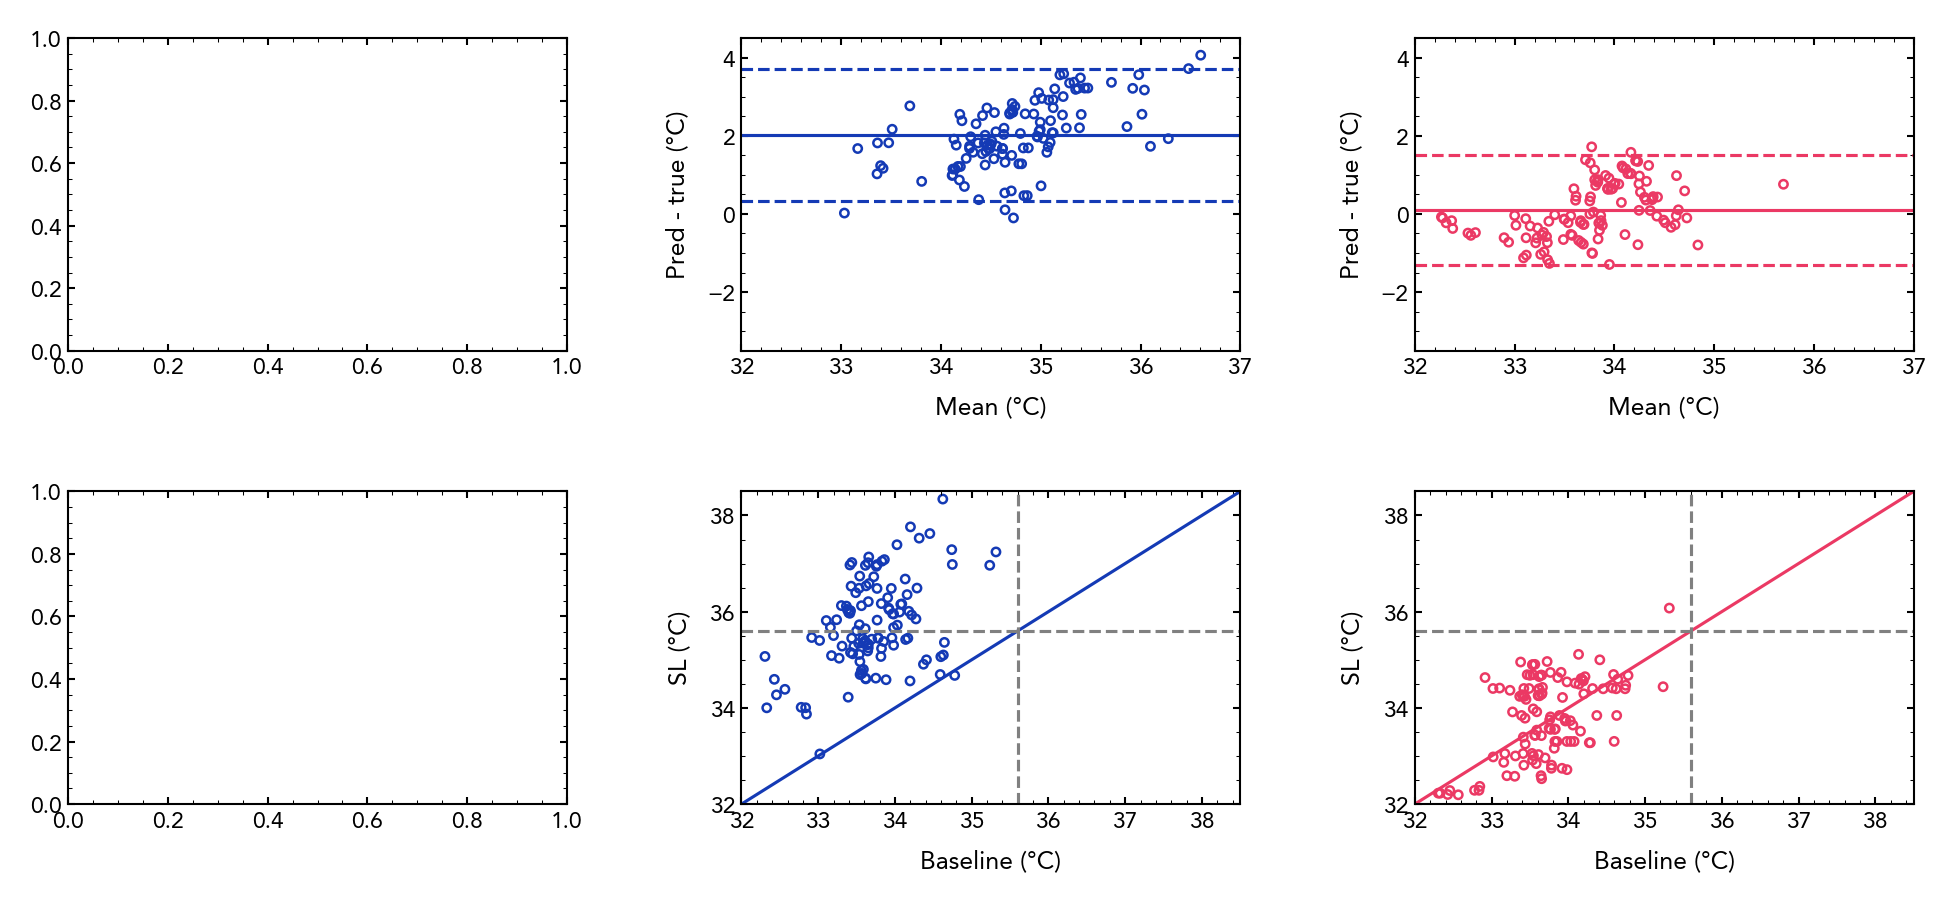

In [50]:
# Same plot limits

corr = cool_df['gt_base_forehead'][::50]
uncorr = cool_df['gt_temp_forehead'][::50]
gt = cool_df['est_base_forehead'][::50]
irt_sl = conv_temp(cool_df.groupby('sid').head(1)['Purple 1'], 'F', 'C')
irt_base = conv_temp(cool_df.groupby('sid').head(1)['Purple 0'], 'F', 'C')
oral = conv_temp(cool_df.groupby('sid').head(1)['oral'], 'F', 'C')


fig, axes = plt.subplots(2, 3, figsize=(6.5, 3))

ax = axes[0][1]
bland_altman_plot(uncorr, gt, ax)
ax.set_xlim(32, 37)
ax.set_ylim(-3.5, 4.5)
ax.set_ylabel('Pred - true (°C)')
ax.set_xlabel('Mean (°C)')
# ax.set_title('Skin temperature')

ax = axes[0][2]
bland_altman_plot(corr, gt, ax, c='#EB3964')
ax.set_xlim(32, 37)
ax.set_ylim(-3.5, 4.5)
ax.set_ylabel('Pred - true (°C)')
ax.set_xlabel('Mean (°C)')
# ax.set_title('Skin temperature')

ax = axes[1][1]
scatter_plot(uncorr, gt, ax, vmin=32, vmax=38.5)
ax.set_xlabel('Baseline (°C)')
ax.set_ylabel('SL (°C)')
ax.set_xlim(32, 38.5)
ax.set_ylim(32, 38.5)
print(scipy.stats.pearsonr(uncorr, gt))

ax = axes[1][2]
scatter_plot(corr, gt, ax, vmin=32, vmax=38.5, c='#EB3964')
ax.set_xlim(32, 38.5)
ax.set_ylim(32, 38.5)
ax.set_xlabel('Baseline (°C)')
ax.set_ylabel('SL (°C)')

print(scipy.stats.pearsonr(corr, gt))
print('n=', len(corr))
print('n=', len(irt_sl))


fig.tight_layout()
fig.subplots_adjust(wspace=0.35, hspace=0.45)
fig.savefig('./exports/bland_altman_new.eps', dpi=300)

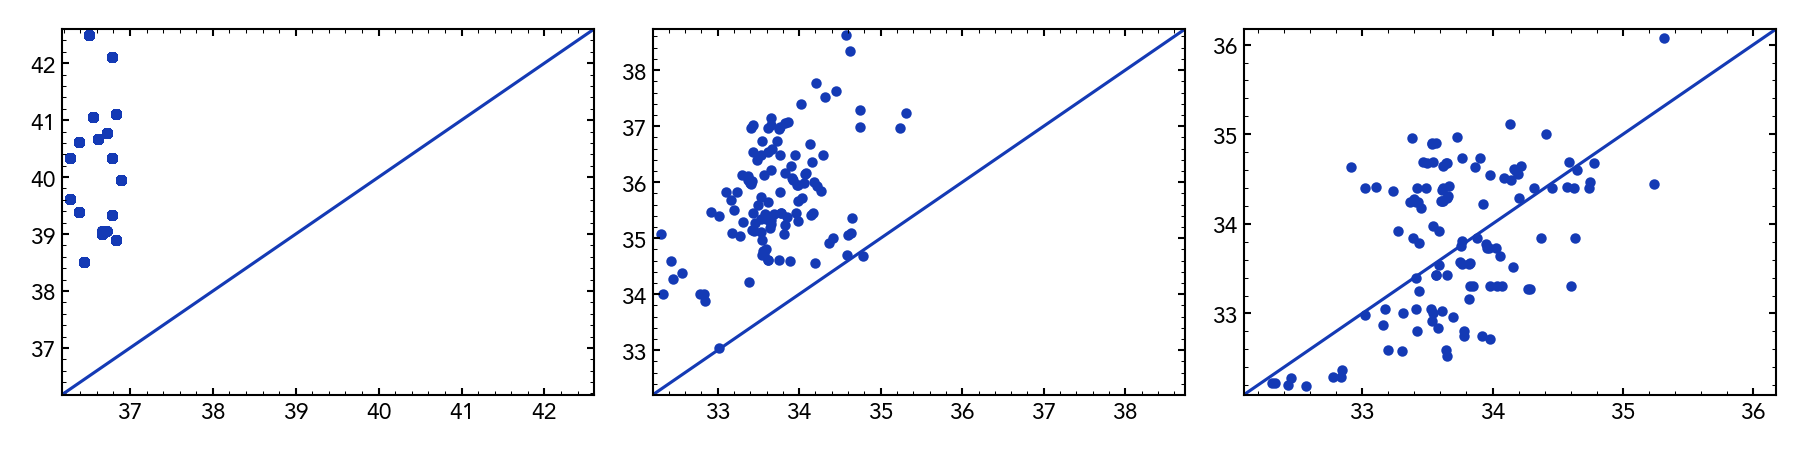

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(6, 1.5))

scatter_plot(irt_sl, irt_base, axes[0])

scatter_plot(uncorr, gt, axes[1])

scatter_plot(corr, gt, axes[2])

fig.tight_layout()

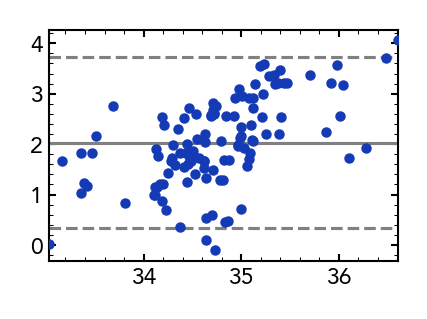

In [ ]:
# plt.scatter(x, y, alpha=0.5)
# vmin = min(x.min(), y.min())
# vmax = min(x.max(), y.max())

# plt.plot([vmin, vmax], [vmin, vmax])
# scipy.stats.pearsonr(y, x)

bland_altman_plot(uncorr, gt)

PearsonRResult(statistic=0.07445294128704488, pvalue=1.0607455631302513e-08)

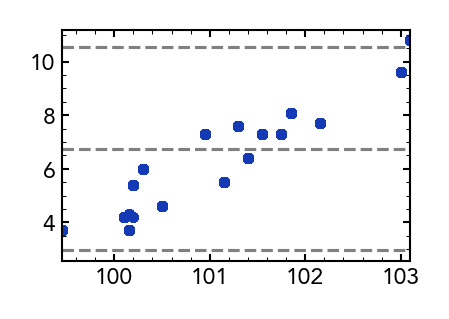

In [ ]:
x = cool_df['Purple 1'][:]
y = cool_df['Purple 0'][:]
# plt.scatter(x, y, alpha=0.5)
# vmin = min(x.min(), y.min())
# vmax = min(x.max(), y.max())

# plt.plot([vmin, vmax], [vmin, vmax])
# scipy.stats.pearsonr(y, x)

bland_altman_plot(x, y)
scipy.stats.pearsonr(y, x)

In [ ]:
df = pd.read_csv('./saves/final_test_results.csv')
df = df.iloc[:, 1:]
base_df = df[df['fname'].str.contains('base_')]
cool_df = df[df['fname'].str.contains('cool_')]
df

,fname,est_base_forehead,gt_base_forehead,est_temp_forehead,gt_temp_forehead,sid,Unnamed: 0,temp_env,rh,fst,...,Purple 0,Purple 1,Purple 2,Sejoy 0,Sejoy 1,Sejoy 2,ADC 0,ADC 1,ADC 2,solar
0,0117_irb2_cool_0,33.614750,34.380200,36.902573,36.962444,0117_irb2,0,70.0,33.0,4.0,...,98.1,105.4,98.5,98.2,105.9,98.7,98.3,107.2,98.7,1100
1,0117_irb2_cool_1,33.756477,34.045734,37.019050,37.069614,0117_irb2,0,70.0,33.0,4.0,...,98.1,105.4,98.5,98.2,105.9,98.7,98.3,107.2,98.7,1100
2,0117_irb2_cool_2,33.754936,34.081580,36.974266,37.027187,0117_irb2,0,70.0,33.0,4.0,...,98.1,105.4,98.5,98.2,105.9,98.7,98.3,107.2,98.7,1100
3,0117_irb2_cool_3,33.816930,34.081580,36.963890,37.014340,0117_irb2,0,70.0,33.0,4.0,...,98.1,105.4,98.5,98.2,105.9,98.7,98.3,107.2,98.7,1100
4,0117_irb2_cool_4,33.908504,34.081580,36.977615,37.019604,0117_irb2,0,70.0,33.0,4.0,...,98.1,105.4,98.5,98.2,105.9,98.7,98.3,107.2,98.7,1100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7493,1213_ellin_fever_133,35.428530,35.711850,35.788406,35.711850,1213_ellin,0,70.0,35.0,3.0,...,98.2,104.6,98.0,98.5,107.4,98.7,98.6,106.3,98.5,1100
7494,1213_ellin_fever_37,34.644085,34.893623,34.963630,34.893623,1213_ellin,0,70.0,35.0,3.0,...,98.2,104.6,98.0,98.5,107.4,98.7,98.6,106.3,98.5,1100
7495,1213_ellin_fever_110,34.737053,34.999928,35.070070,34.999928,1213_ellin,0,70.0,35.0,3.0,...,98.2,104.6,98.0,98.5,107.4,98.7,98.6,106.3,98.5,1100
7496,1213_ellin_fever_4,35.589810,35.995110,36.067610,35.995110,1213_ellin,0,70.0,35.0,3.0,...,98.2,104.6,98.0,98.5,107.4,98.7,98.6,106.3,98.5,1100


In [ ]:
df = pd.read_csv('./saves/final_test_results.csv')
df = df.iloc[:, 1:]
base_df = df[df['fname'].str.contains('base_')]
cool_df = df[df['fname'].str.contains('cool_')]

all_mean = []
for session_df in [base_df, cool_df]:
    gt = session_df['gt_base_forehead']
    est = session_df['gt_temp_forehead']
    mean = np.array([fn(gt.to_numpy(), est.to_numpy()) for fn in fns])
    all_mean += [mean]
all_mean += [np.mean(all_mean[:2], axis=0)]
disp_df = pd.DataFrame(data=np.vstack(all_mean), columns=err_cols, index=sessions)
disp_df = disp_df.reset_index()
disp_df = disp_df.rename(columns={'index': 'Session'})
disp_df[' '] = ['No correction', ' ', ' ']
cols = disp_df.columns.tolist()
disp_df = disp_df[cols[-1:] + cols[:-1]]
disp_nocorr_df = disp_df

# ---------------------------------------------------------------
df = pd.read_csv('./saves/mlp_test_results.csv')
df = df.iloc[:, 1:]
df = df.rename(columns={'Unnamed: 0': 'fname'})
base_df = df[df['fname'].str.contains('base_')]
cool_df = df[df['fname'].str.contains('cool_')]

all_mean = []
for session_df in [base_df, cool_df]:
    gt = session_df['gt_base_forehead']
    est = session_df['est_base_forehead']
    mean = np.array([fn(gt.to_numpy(), est.to_numpy()) for fn in fns])
    all_mean += [mean]
all_mean += [np.mean(all_mean[:2], axis=0)]
disp_df = pd.DataFrame(data=np.vstack(all_mean), columns=err_cols, index=sessions)
disp_df = disp_df.reset_index()
disp_df = disp_df.rename(columns={'index': 'Session'})
disp_df[' '] = ['MLP', ' ', ' ']
cols = disp_df.columns.tolist()
disp_df = disp_df[cols[-1:] + cols[:-1]]
disp_mlp_df = disp_df

# -----------------------------------------------------------
df = pd.read_csv('./saves/final_test_results.csv')
df = df.iloc[:, 1:]
base_df = df[df['fname'].str.contains('base_')]
cool_df = df[df['fname'].str.contains('cool_')]
all_mean = []
for session_df in [base_df, cool_df]:
    gt = session_df['gt_base_forehead']
    est = session_df['est_base_forehead']
    mean = np.array([fn(gt.to_numpy(), est.to_numpy()) for fn in fns])
    all_mean += [mean]
all_mean += [np.mean(all_mean[:2], axis=0)]

disp_df = pd.DataFrame(data=np.vstack(all_mean), columns=err_cols, index=sessions)
disp_df = disp_df.reset_index()
disp_df = disp_df.rename(columns={'index': 'Session'})
disp_df[' '] = ['Ours', ' ', ' ']
cols = disp_df.columns.tolist()
disp_df = disp_df[cols[-1:] + cols[:-1]]
disp_cnn_df = disp_df

# ----------------------------------------------------------------------
df = pd.read_csv('./saves/exp_fit_data.csv')
base_df = df[df['session'] == 'base']
cool_df = df[df['session'] == 'cool']

all_mean = []
for session_df in [base_df, cool_df]:
    gt = session_df['gt_base_forehead']
    est = session_df['est_base_forehead']
    mean = np.array([fn(gt.to_numpy(), est.to_numpy()) for fn in fns])
    all_mean += [mean]
all_mean += [np.mean(all_mean[:2], axis=0)]
all_mean
disp_df = pd.DataFrame(data=np.vstack(all_mean), columns=err_cols, index=sessions)
disp_df = disp_df.reset_index()
disp_df = disp_df.rename(columns={'index': 'Session'})
disp_df[' '] = ['Exponential Fit', ' ', ' ']
cols = disp_df.columns.tolist()
disp_df = disp_df[cols[-1:] + cols[:-1]]
disp_exp_df = disp_df


# ----------------------------------------------------------------------
results_df = pd.concat([disp_nocorr_df, disp_exp_df, disp_mlp_df, disp_cnn_df])
for col in err_cols:
    results_df[col] = results_df[col].apply(lambda x: f'{x:.3f}')
results_df.to_csv('./saves/full_results.csv', index=False)
results_df

,,Session,MAE,MSE,RMSE,MAPE
0,No correction,Base,0.000,0.000,0.000,0.000
1,,Cool,1.999,4.889,2.211,0.059
2,,Mean,1.000,2.444,1.106,0.030
0,Exponential Fit,Base,0.361,1.222,1.105,0.011
1,,Cool,1.380,2.408,1.552,0.041
2,,Mean,0.871,1.815,1.329,0.026
0,MLP,Base,0.354,0.199,0.446,0.010
1,,Cool,0.700,0.661,0.813,0.021
2,,Mean,0.527,0.430,0.630,0.016
0,Ours,Base,0.216,0.113,0.336,0.006


### <font face="Avenir" size=3>Table option 2<font>

In [ ]:
df = pd.read_csv('./saves/final_test_results.csv')
df = df.iloc[:, 1:]
base_df = df[df['fname'].str.contains('base_')]
cool_df = df[df['fname'].str.contains('cool_')]
all_mean = []
for session_df in [base_df, cool_df]:
    gt = session_df['gt_base_forehead']
    est = session_df['gt_temp_forehead']
    mean = np.array([fn(gt.to_numpy(), est.to_numpy()) for fn in fns])
    all_mean += [mean]
all_mean += [np.mean(all_mean[:2], axis=0)]
all_mean = np.hstack(np.vstack(all_mean).T).reshape(1, -1)
disp_df = pd.DataFrame(data=all_mean, columns=sessions*4, index=['No correction'])
disp_nocorr_df = disp_df

# ------------------------------------------------------------
df = pd.read_csv('./saves/final_test_results.csv')
df = df.iloc[:, 1:]
base_df = df[df['fname'].str.contains('base_')]
cool_df = df[df['fname'].str.contains('cool_')]
all_mean = []
for session_df in [base_df, cool_df]:
    gt = session_df['gt_base_forehead']
    est = session_df['est_base_forehead']
    mean = np.array([fn(gt.to_numpy(), est.to_numpy()) for fn in fns])
    all_mean += [mean]
all_mean += [np.mean(all_mean[:2], axis=0)]
all_mean = np.hstack(np.vstack(all_mean).T).reshape(1, -1)
disp_df = pd.DataFrame(data=all_mean, columns=sessions*4, index=['Ours (ResUNet)'])
disp_cnn_df = disp_df

# ------------------------------------------------------------------------
df = pd.read_csv('./saves/mlp_test_results.csv')
df = df.iloc[:, 1:]
df = df.rename(columns={'Unnamed: 0': 'fname'})
base_df = df[df['fname'].str.contains('base_')]
cool_df = df[df['fname'].str.contains('cool_')]
all_mean = []
for session_df in [base_df, cool_df]:
    gt = session_df['gt_base_forehead']
    est = session_df['est_base_forehead']
    mean = np.array([fn(gt.to_numpy(), est.to_numpy()) for fn in fns])
    all_mean += [mean]
all_mean += [np.mean(all_mean[:2], axis=0)]
all_mean = np.hstack(np.vstack(all_mean).T).reshape(1, -1)
disp_df = pd.DataFrame(data=all_mean, columns=sessions*4, index=['Ours (MLP)'])
disp_mlp_df = disp_df
disp_mlp_df

# ----------------------------------------------------------------------

df = pd.read_csv('./saves/exp_fit_data.csv')
base_df = df[df['session'] == 'base']
cool_df = df[df['session'] == 'cool']

all_mean = []
for session_df in [base_df, cool_df]:
    gt = session_df['gt_base_forehead']
    est = session_df['est_base_forehead']
    mean = np.array([fn(gt.to_numpy(), est.to_numpy()) for fn in fns])
    all_mean += [mean]
all_mean += [np.mean(all_mean[:2], axis=0)]
all_mean = np.hstack(np.vstack(all_mean).T).reshape(1, -1)
disp_df = pd.DataFrame(data=all_mean, columns=sessions*4, index=['Ours (Exp Fit)'])
disp_exp_df = disp_df

# ----------------------------------------------------------------------
results_df = pd.concat([disp_nocorr_df, disp_exp_df, disp_mlp_df, disp_cnn_df])
for i in range(len(results_df.columns)):
    results_df.iloc[:, i] = results_df.iloc[:, i].apply(lambda x: f'{x:.3f}')
results_df.to_csv('./saves/full_results_flat_table.csv')
results_df


,Base,Cool,Mean,Base,Cool,Mean,Base,Cool,Mean,Base,Cool,Mean
No correction,0.000,1.999,1.000,0.000,4.889,2.444,0.000,2.211,1.106,0.000,0.059,0.030
Ours (Exp Fit),0.361,1.380,0.871,1.222,2.408,1.815,1.105,1.552,1.329,0.011,0.041,0.026
Ours (MLP),0.354,0.700,0.527,0.199,0.661,0.430,0.446,0.813,0.630,0.010,0.021,0.016
Ours (ResUNet),0.216,0.656,0.436,0.113,0.593,0.353,0.336,0.770,0.553,0.006,0.019,0.013


### <font face="Avenir" size=3>3.1 Correlation over time and SL levels<font>

In [ ]:
df = pd.read_csv('./saves/final_test_results.csv')
df = df.iloc[:, 1:]
df

,fname,est_base_forehead,gt_base_forehead,est_temp_forehead,gt_temp_forehead,sid,Unnamed: 0,temp_env,rh,fst,...,Purple 0,Purple 1,Purple 2,Sejoy 0,Sejoy 1,Sejoy 2,ADC 0,ADC 1,ADC 2,solar
0,0117_irb2_cool_0,33.614750,34.380200,36.902573,36.962444,0117_irb2,0,70.0,33.0,4.0,...,98.1,105.4,98.5,98.2,105.9,98.7,98.3,107.2,98.7,1100
1,0117_irb2_cool_1,33.756477,34.045734,37.019050,37.069614,0117_irb2,0,70.0,33.0,4.0,...,98.1,105.4,98.5,98.2,105.9,98.7,98.3,107.2,98.7,1100
2,0117_irb2_cool_2,33.754936,34.081580,36.974266,37.027187,0117_irb2,0,70.0,33.0,4.0,...,98.1,105.4,98.5,98.2,105.9,98.7,98.3,107.2,98.7,1100
3,0117_irb2_cool_3,33.816930,34.081580,36.963890,37.014340,0117_irb2,0,70.0,33.0,4.0,...,98.1,105.4,98.5,98.2,105.9,98.7,98.3,107.2,98.7,1100
4,0117_irb2_cool_4,33.908504,34.081580,36.977615,37.019604,0117_irb2,0,70.0,33.0,4.0,...,98.1,105.4,98.5,98.2,105.9,98.7,98.3,107.2,98.7,1100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7493,1213_ellin_fever_133,35.428530,35.711850,35.788406,35.711850,1213_ellin,0,70.0,35.0,3.0,...,98.2,104.6,98.0,98.5,107.4,98.7,98.6,106.3,98.5,1100
7494,1213_ellin_fever_37,34.644085,34.893623,34.963630,34.893623,1213_ellin,0,70.0,35.0,3.0,...,98.2,104.6,98.0,98.5,107.4,98.7,98.6,106.3,98.5,1100
7495,1213_ellin_fever_110,34.737053,34.999928,35.070070,34.999928,1213_ellin,0,70.0,35.0,3.0,...,98.2,104.6,98.0,98.5,107.4,98.7,98.6,106.3,98.5,1100
7496,1213_ellin_fever_4,35.589810,35.995110,36.067610,35.995110,1213_ellin,0,70.0,35.0,3.0,...,98.2,104.6,98.0,98.5,107.4,98.7,98.6,106.3,98.5,1100


In [ ]:
cool_df = df[df['fname'].str.contains('_cool_')]
timestamp = cool_df['fname'].str.split('_').apply(lambda x: x[-1])
timestamp = pd.to_numeric(timestamp)
corr_over_time = []

step = 15
for d in np.arange(step, 130, step=step):
    curr_df = cool_df[(timestamp < 4 * d) & (timestamp >= 4 * (d - step))]
    y = curr_df['est_base_forehead']
    x = curr_df['gt_base_forehead']
    corr_over_time += [(d, pearsonr(x, y).statistic)]
corr_over_time = np.array(corr_over_time)

Text(0, 0.5, 'R')

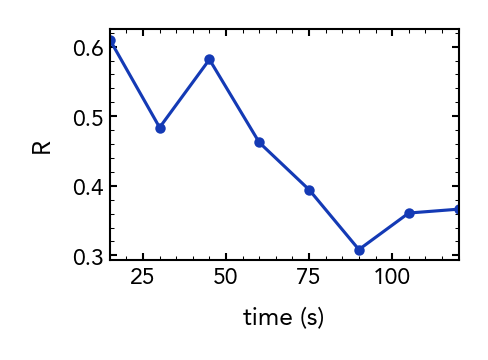

In [ ]:
plt.plot(corr_over_time[:, 0], corr_over_time[:, 1], '-o')
plt.xlabel('time (s)')
plt.ylabel('R')

In [ ]:
cool_df['sl_dif'].describe()

count    5890.000000
mean        1.997781
std         0.947499
min        -0.324558
25%         1.322984
50%         1.977388
75%         2.642653
max         4.441010
Name: sl_dif, dtype: float64

Text(0, 0.5, 'MAE (°C)')

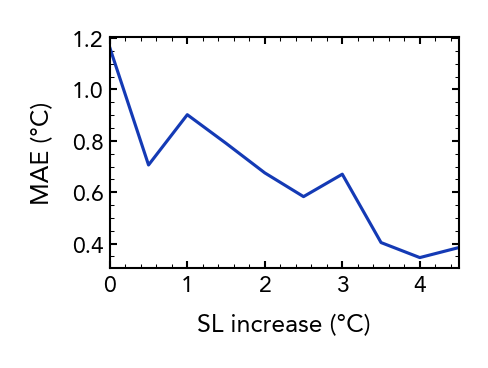

In [ ]:
cool_df = df[df['fname'].str.contains('_cool_')]
cool_df = cool_df[['gt_base_forehead', 'gt_temp_forehead', 'est_base_forehead', 'est_temp_forehead']]
cool_df['sl_dif'] = cool_df['gt_temp_forehead'] - cool_df['gt_base_forehead']

cool_df = cool_df.sort_values('sl_dif')
bins =  np.arange(0., 5.0, 0.5)
ind = np.digitize(cool_df['sl_dif'], bins)
cool_df = cool_df.groupby(ind)[['gt_base_forehead', 'est_base_forehead']].agg(list)

# corr_over_sl = cool_df.apply(lambda x: pearsonr(x.gt_base_forehead, x.est_base_forehead)[0], axis=1)
corr_over_sl = cool_df.apply(lambda x: np.abs(np.array(x.gt_base_forehead) - np.array(x.est_base_forehead)).mean(), axis=1)
std_over_sl = cool_df.apply(lambda x: np.abs(np.array(x.gt_base_forehead) - np.array(x.est_base_forehead)).std(), axis=1)

plt.errorbar(bins, corr_over_sl, ) #yerr=std_over_sl)
plt.xlabel('SL increase (°C)')
plt.ylabel('MAE (°C)')

In [ ]:
sids = np.unique(df['sid'])

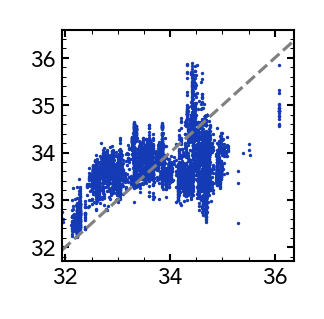

In [ ]:
# sub_df = df[df['sid'] == sids[3]]
# sub_df = sub_df[sub_df['fname'].str.contains('_cool_')]

x, y = cool_df['gt_base_forehead'], cool_df['est_base_forehead']
vmin = min(x.min(), y.min())
vmax = max(x.max(), y.max())
plt.figure(figsize=(1, 1))
plt.scatter(x, y, s=0.1, alpha=1)
plt.plot([vmin, vmax], [vmin, vmax], color='gray', linestyle='--')

SignificanceResult(statistic=-0.32151435647372556, pvalue=1.0010177888786755e-141)

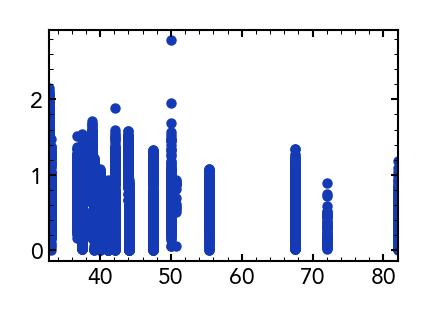

In [ ]:
cool_df = df[df['fname'].str.contains('_cool_')]
x = cool_df['M']
y = np.abs(cool_df['gt_base_forehead'] - cool_df['est_base_forehead'])
plt.scatter(x, y)
spearmanr(x, y)

SignificanceResult(statistic=0.15312504186854464, pvalue=3.111703360062865e-32)

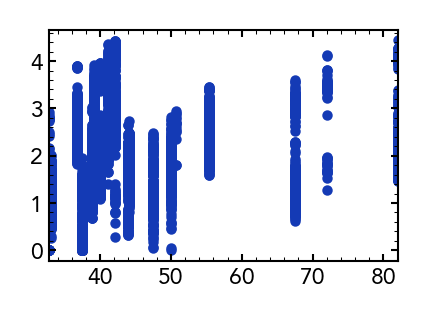

In [ ]:
cool_df = df[df['fname'].str.contains('_cool_')]
x = cool_df['M']
y = np.abs(cool_df['gt_base_forehead'] - cool_df['gt_temp_forehead'])
plt.scatter(x, y)
spearmanr(x, y)

In [ ]:
from sklearn.metrics import r2_score, explained_variance_score

11 SignificanceResult(statistic=-0.06095238095238095, pvalue=0.7624419520046468)


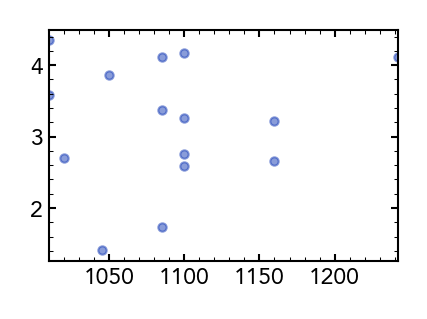

In [ ]:
# cool_df['gt_temp_forehead'] - cool_df['gt_base_forehead']
idx = pd.to_numeric(cool_df['fname'].str.split('_').apply(lambda x: x[-1]))

idx_mask = idx < 1
m = cool_df[idx_mask]['M']
solar = cool_df[idx_mask]['solar']
err = cool_df[idx_mask]['gt_temp_forehead'] - cool_df[idx_mask]['gt_base_forehead']
err = np.abs(err)
plt.scatter(solar, err, alpha=0.5)
print(i, kendalltau(solar, err, variant='c'))

,fname,est_base_forehead,gt_base_forehead,est_temp_forehead,gt_temp_forehead,sid,Unnamed: 0,temp_env,rh,fst,...,Purple 0,Purple 1,Purple 2,Sejoy 0,Sejoy 1,Sejoy 2,ADC 0,ADC 1,ADC 2,solar
0,0117_irb2_cool_0,33.614750,34.380200,36.902573,36.962444,0117_irb2,0,70.0,33.0,4.0,...,98.1,105.4,98.5,98.2,105.9,98.7,98.3,107.2,98.7,1100
462,1219_zhen_cool_0,33.249650,32.717247,36.256252,36.304466,1219_zhen,0,71.0,29.0,2.0,...,97.5,105.1,98.6,97.0,106.2,98.7,98.2,104.6,98.6,1010
940,1106_agnes_cool_0,34.933740,34.412033,38.478806,38.526400,1106_agnes,0,77.3,47.5,6.0,...,98.0,102.3,98.6,97.8,106.4,98.3,97.2,103.9,96.8,1085
1005,1010_kendall_cool_0,34.695198,34.396810,38.676846,38.744730,1010_kendall,0,77.0,69.5,2.0,...,98.3,106.0,98.4,98.7,108.0,98.5,98.5,105.4,98.3,1010
1699,1213_rishi_cool_0,33.010260,33.051765,34.782616,34.788223,1213_rishi,0,69.4,32.0,4.0,...,97.9,105.2,97.9,97.6,105.9,97.9,98.3,103.7,98.4,1085
2899,1004_kaanthi_cool_0,33.366653,32.809100,35.483800,35.509884,1004_kaanthi,0,76.8,52.5,5.0,...,98.1,102.3,98.2,98.4,104.1,98.1,98.3,104.5,98.0,1020
2920,1012_meryl_cool_0,34.047443,34.383540,37.103794,37.143970,1012_meryl,0,78.0,52.0,4.0,...,98.2,102.8,98.4,98.1,106.2,98.4,98.4,104.4,98.4,1100
3257,1122_jeannette_cool_0,33.870205,34.538720,37.121540,37.192516,1122_jeannette,0,74.0,25.0,3.0,...,98.2,107.8,98.5,98.5,109.0,98.7,98.4,106.4,98.4,1160
3548,0511_laleh_cool_0,33.070435,34.546020,35.918575,35.954990,0511_laleh,0,75.0,46.0,2.0,...,97.6,101.3,98.7,97.3,104.4,99.1,98.2,99.5,99.0,1045
3905,1213_ethan_cool_0,32.956112,33.306026,36.591200,36.678825,1213_ethan,0,69.4,32.0,3.0,...,97.8,105.9,98.7,97.5,106.4,98.2,98.2,106.2,98.6,1085


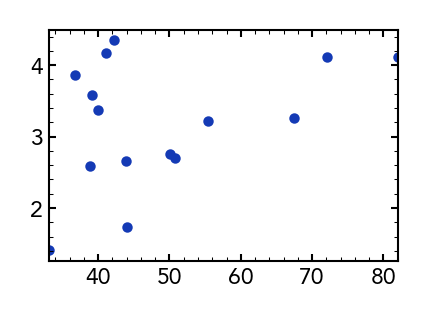

In [ ]:
test = cool_df[idx_mask]
plt.scatter(test['M'],
         test['gt_temp_forehead'] - test['gt_base_forehead'])
test['gt_temp_forehead'] - test['gt_base_forehead']
test

11 SignificanceResult(statistic=-0.07381002072121763, pvalue=0.09365917017600675)


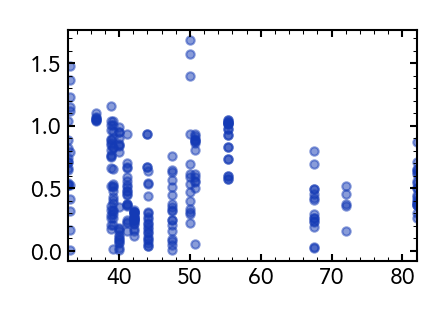

In [ ]:
# cool_df['gt_temp_forehead'] - cool_df['gt_base_forehead']
idx = pd.to_numeric(cool_df['fname'].str.split('_').apply(lambda x: x[-1]))
idx_mask = idx < 4 * 5
m = cool_df[idx_mask]['M']
err = cool_df[idx_mask]['est_base_forehead'] - cool_df[idx_mask]['gt_base_forehead']
err = np.abs(err)
plt.scatter(m, err, alpha=0.5)
print(i, kendalltau(m, err, variant='c'))

## <font face="Avenir" size=4>Bias Analysis<font>

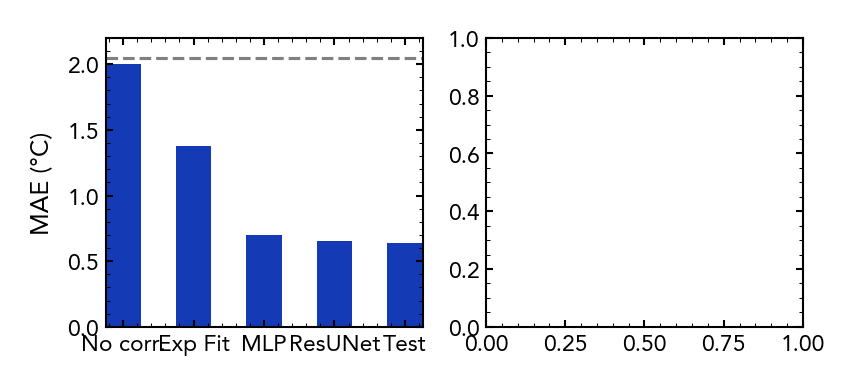

In [ ]:
df = pd.read_csv('./saves/mlp_test_results.csv')
df = df.iloc[:, 1:]
df = df.rename(columns={'Unnamed: 0': 'fname'})
cool_df = df[df['fname'].str.contains('cool_')]
mlp = np.abs(cool_df['est_base_forehead'] - cool_df['gt_base_forehead']).mean()

df = pd.read_csv('./saves/final_test_results.csv')
df = df.iloc[:, 1:]
cool_df = df[df['fname'].str.contains('cool_')]
nocorr = np.abs(cool_df['gt_temp_forehead'] - cool_df['gt_base_forehead']).mean()
cnn = np.abs(cool_df['est_base_forehead'] - cool_df['gt_base_forehead']).mean()

df = pd.read_csv('./saves/classifier/test.csv')
df = df.iloc[:, 1:]
mask = df['est_label'] == 1
df.loc[mask, 'est_base_forehead'] = df.loc[mask, 'gt_base_forehead']
cool_df = df[df['fname'].str.contains('cool_')]
classifier = np.abs(cool_df['est_base_forehead'] - cool_df['gt_base_forehead']).mean()

df = pd.read_csv('./saves/exp_fit_data.csv')
cool_df = df[df['session'] == 'cool']
expfit = np.abs(cool_df['est_base_forehead'] - cool_df['gt_base_forehead']).mean()

x = ['No corr.', 'Exp Fit', 'MLP', 'ResUNet', 'Test']
y = [nocorr, expfit, mlp, cnn, classifier]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3, 1.25))

ax = ax1
ax.bar(x, y, width=0.5)
ax.set_ylabel('MAE (°C)', labelpad=3)
ax.set_ylim(0, 2.2)
ax.axhline(2.05, color='gray', linestyle='--');


# -------------------------------------------------------

# from sklearn import metrics

# df = pd.read_csv('./saves/final_test_results.csv')
# df = df.iloc[:, 1:]
# cool_df = df[df['fname'].str.contains('cool_')]
# gt = cool_df['gt_base_forehead'] > 35.35
# est = cool_df['est_base_forehead']
# sl = cool_df['gt_temp_forehead']

# fpr, tpr, threshold = metrics.roc_curve(gt, est)
# roc_auc = metrics.auc(fpr, tpr)
# ax2.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
# ax2.legend(loc='lower right', edgecolor='white')
# ax2.plot([0, 1], [0, 1], '--', color='gray')
# ax2.set_ylabel('True positive rate', labelpad=3)
# ax2.set_xlabel('False positive rate')

# fig.tight_layout()
# fig.subplots_adjust(wspace=0.45)
# fig.savefig('./exports/fever.eps')

In [ ]:
df = pd.read_csv('./saves/final_test_results.csv')
df = df.iloc[:, 1:]
base_df = df[df['fname'].str.contains('base_')]
cool_df = df[df['fname'].str.contains('cool_')]

all_mean = []
for session_df in [base_df, cool_df]:
    gt = session_df['gt_base_forehead']
    est = session_df['gt_temp_forehead']
    mean = np.array([fn(gt.to_numpy(), est.to_numpy()) for fn in fns])
    all_mean += [mean]
all_mean += [np.mean(all_mean[:2], axis=0)]
disp_df = pd.DataFrame(data=np.vstack(all_mean), columns=err_cols, index=sessions)
disp_df = disp_df.reset_index()
disp_df = disp_df.rename(columns={'index': 'Session'})
disp_df[' '] = ['No correction', ' ', ' ']
cols = disp_df.columns.tolist()
disp_df = disp_df[cols[-1:] + cols[:-1]]
disp_nocorr_df = disp_df

# ---------------------------------------------------------------
df = pd.read_csv('./saves/mlp_test_results.csv')
df = df.iloc[:, 1:]
df = df.rename(columns={'Unnamed: 0': 'fname'})
base_df = df[df['fname'].str.contains('base_')]
cool_df = df[df['fname'].str.contains('cool_')]

all_mean = []
for session_df in [base_df, cool_df]:
    gt = session_df['gt_base_forehead']
    est = session_df['est_base_forehead']
    mean = np.array([fn(gt.to_numpy(), est.to_numpy()) for fn in fns])
    all_mean += [mean]
all_mean += [np.mean(all_mean[:2], axis=0)]
disp_df = pd.DataFrame(data=np.vstack(all_mean), columns=err_cols, index=sessions)
disp_df = disp_df.reset_index()
disp_df = disp_df.rename(columns={'index': 'Session'})
disp_df[' '] = ['MLP', ' ', ' ']
cols = disp_df.columns.tolist()
disp_df = disp_df[cols[-1:] + cols[:-1]]
disp_mlp_df = disp_df

# -----------------------------------------------------------
df = pd.read_csv('./saves/final_test_results.csv')
df = df.iloc[:, 1:]
base_df = df[df['fname'].str.contains('base_')]
cool_df = df[df['fname'].str.contains('cool_')]
all_mean = []
for session_df in [base_df, cool_df]:
    gt = session_df['gt_base_forehead']
    est = session_df['est_base_forehead']
    mean = np.array([fn(gt.to_numpy(), est.to_numpy()) for fn in fns])
    all_mean += [mean]
all_mean += [np.mean(all_mean[:2], axis=0)]

disp_df = pd.DataFrame(data=np.vstack(all_mean), columns=err_cols, index=sessions)
disp_df = disp_df.reset_index()
disp_df = disp_df.rename(columns={'index': 'Session'})
disp_df[' '] = ['Ours', ' ', ' ']
cols = disp_df.columns.tolist()
disp_df = disp_df[cols[-1:] + cols[:-1]]
disp_cnn_df = disp_df

# ----------------------------------------------------------------------
df = pd.read_csv('./saves/exp_fit_data.csv')
base_df = df[df['session'] == 'base']
cool_df = df[df['session'] == 'cool']

all_mean = []
for session_df in [base_df, cool_df]:
    gt = session_df['gt_base_forehead']
    est = session_df['est_base_forehead']
    mean = np.array([fn(gt.to_numpy(), est.to_numpy()) for fn in fns])
    all_mean += [mean]
all_mean += [np.mean(all_mean[:2], axis=0)]
all_mean
disp_df = pd.DataFrame(data=np.vstack(all_mean), columns=err_cols, index=sessions)
disp_df = disp_df.reset_index()
disp_df = disp_df.rename(columns={'index': 'Session'})
disp_df[' '] = ['Exponential Fit', ' ', ' ']
cols = disp_df.columns.tolist()
disp_df = disp_df[cols[-1:] + cols[:-1]]
disp_exp_df = disp_df


# ----------------------------------------------------------------------
results_df = pd.concat([disp_nocorr_df, disp_exp_df, disp_mlp_df, disp_cnn_df])
for col in err_cols:
    results_df[col] = results_df[col].apply(lambda x: f'{x:.3f}')
results_df.to_csv('./saves/full_results.csv', index=False)
results_df

In [ ]:
def get_sids(k):
    # Return train and test/val SIDS
    if k == 'test':
        fname1 = '/content/ml_data/test.csv'
        fname2 = '/content/ml_data/train.csv'
    else:
        fname1 = f'./folds_0419/fold{k}/val.csv'
        fname2 = f'./folds_0419/fold{k}/train.csv'
    return list(pd.read_csv(fname2)['0']), list(pd.read_csv(fname1)['0'])


def get_data(sid, i):
    meta_df = pd.read_csv(f'/content/ml_data/{sid}/metadata.csv')
    M = meta_df['M'].item()
    FST = meta_df['fst'].item()
    solar = meta_df['solar'].item()

    df = pd.read_csv(f'/content/ml_data/{sid}/full_labels.csv')
    df = df[df['ir_fname'].str.contains('cool_')]
    time = pd.to_numeric(df['ir_fname'].str.extract('[a-z]{4}_ir([0-9]+).png')[0])
    df['time'] = time

    df = df[['cool_forehead', 'base_forehead', 'time']]
    df['cool_forehead'] = df['cool_forehead'].apply(lambda x: conv_temp(x, 'F', 'C'))
    df['base_forehead'] = df['base_forehead'].apply(lambda x: conv_temp(x, 'F', 'C'))
    df['M'] = M
    df['FST'] = FST
    df['solar'] = solar
    df = df.sort_values('time')
    df = df.iloc[:i]
    # df = df[df['time'] < i]
    if len(df) == 0:
        print(sid)
        return None
    return df


from scipy import stats

train_sids, val_sids = get_sids(0)
_, test_sids = get_sids('test')
sids = train_sids + val_sids + test_sids

# Dataset vals

data = []
data = [get_data(sid, 1) for sid in sids]
data = [x for x in data if x is not None]
df = pd.concat(data)
df = df[df['M'] > 0]
m_dataset = df['M']
fst_dataset = df['FST']

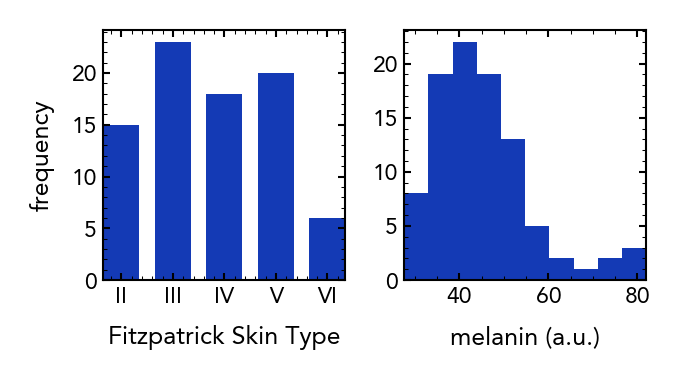

In [ ]:
plt.figure(figsize=(2.25, 1.25))
plt.subplot(121)
labels, counts = np.unique(fst_dataset[fst_dataset > 0], return_counts=True)
plt.bar(labels, counts, align='center', width=0.7)
plt.xticks([2, 3, 4, 5, 6], ['II', 'III', 'IV', 'V', 'VI'])
plt.ylabel('frequency')
plt.xlabel('Fitzpatrick Skin Type')

plt.subplot(122)
plt.hist(m_dataset[m_dataset > 0],bins=10)
plt.xlabel('melanin (a.u.)')
plt.tight_layout()
# plt.savefig('./exports/dataset_demographics.eps', bbox_inches='tight', pad_inches=0.01)

In [ ]:
stats.linregress(y_sl, m, alternative='greater')
stats.linregress(y_est, m)

LinregressResult(slope=-3.2573314394989232, intercept=50.09300840589826, rvalue=-0.08174195476868266, pvalue=0.26348868182257257, stderr=2.904292388288527, intercept_stderr=1.8648550661870982)

In [ ]:
sub_df['oral']

,oral
sid,
0113_lenny,97.8
0117_irb2,97.8
0511_laleh,97.9
0512_selasi,96.0
0517_chris,96.9
1004_kaanthi,98.6
1010_kendall,98.5
1012_meryl,98.1
1106_agnes,97.5


In [ ]:
irt1

array([4.05555556, 4.05555556, 2.05555556, 3.33333333, 2.05555556,
       2.33333333, 4.27777778, 2.55555556, 2.38888889, 2.33333333,
       5.33333333, 6.        , 3.55555556, 4.5       , 4.05555556,
       3.        , 4.22222222])

In [ ]:
sub_df = df.groupby("sid").first()

irt_error = lambda dev: conv_temp(sub_df[f"{dev} 1"], "F", "C") - conv_temp(sub_df[f"{dev} 0"], "F", "C")
irt1 = irt_error("Purple")
irt2 = irt_error("ADC")
irt3 = irt_error("Sejoy")
fst = sub_df["fst"]
m = sub_df["M"]

print(stats.kendalltau(fst, irt1))
print(stats.kendalltau(fst, irt2))
print(stats.kendalltau(fst, irt3))

print(stats.kendalltau(m, irt1))
print(stats.kendalltau(m, irt2))
print(stats.kendalltau(m, irt3))


SignificanceResult(statistic=-0.13576992913511537, pvalue=0.4732901086466619)
SignificanceResult(statistic=0.0, pvalue=1.0)
SignificanceResult(statistic=-0.05549267431802431, pvalue=0.7681158692502905)
SignificanceResult(statistic=-0.014815221273648992, pvalue=0.9342289159609931)
SignificanceResult(statistic=-0.08118136450784207, pvalue=0.6501859872228386)
SignificanceResult(statistic=0.1764705882352941, pvalue=0.34884640290128766)


In [ ]:
print(stats.kendalltau(fst, y_sl))


In [ ]:
print(stats.kendalltau(fst, y_sl))
print(stats.kendalltau(fst, y_est))

SignificanceResult(statistic=-0.06059138684435187, pvalue=0.2586038856584515)
SignificanceResult(statistic=0.020197128948117288, pvalue=0.7064963854045754)


In [ ]:
print(stats.kendalltau(m, y_sl))
print(stats.kendalltau(m, y_est))

SignificanceResult(statistic=0.153015710140809, pvalue=0.002445970153793862)
SignificanceResult(statistic=-0.07438182788344617, pvalue=0.14078483368359457)


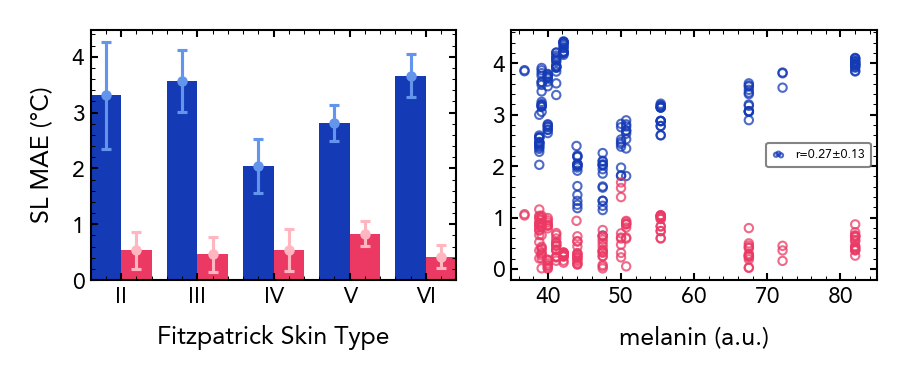

In [ ]:
n = 6
bins = np.linspace(m_dataset.min(), m_dataset.max()+0.1, num=n)
df = pd.read_csv('./saves/classifier/test.csv')
df = df.iloc[:, 1:]
mask = df['est_label'] == 1
df.loc[mask, 'est_base_forehead'] = df.loc[mask, 'gt_base_forehead']
df = df[df['fname'].str.contains('_cool_')]
idx = pd.to_numeric(df['fname'].str.split('_').apply(lambda x: x[-1]))
df = df[(idx < 4*5) & (idx > 4*1)]
y_sl = np.abs(df['gt_temp_forehead'] - df['gt_base_forehead'])
y_sl = y_sl
y_est = np.abs(df['est_base_forehead'] - df['gt_base_forehead'])
m = df['M']
jit = 0 #np.random.uniform(low=-3, high=3, size=m.shape)
grouped_sl = []
grouped_est = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3, 1.25))

res = stats.pearsonr(m, y_sl)
ci = res.confidence_interval(0.95)
ci_val = np.abs(ci.high - res.statistic)
assert res.pvalue < 0.05
ax2.scatter(jit + m, y_sl, alpha=0.75, facecolors='none', edgecolors='#143AB5', label=f'r={res.statistic:.2f}±{ci_val:.2f}')
res = stats.linregress(m, y_sl)
line_fn = lambda x: x * res.slope + res.intercept
xx = np.arange(m.min(), m.max())
# ax2.plot(xx, line_fn(xx))

res = stats.pearsonr(m, y_est)
ci = res.confidence_interval(0.95)
ci_val = np.abs(ci.high - res.statistic)
assert res.pvalue > 0.1
ax2.scatter(jit + m, y_est, alpha=0.75, facecolors='none', edgecolors='#EB3964')
ax2.set_xlabel('melanin (a.u.)')
ax2.set_xlim(35, 85)

ax2.legend(fontsize=3)

bins = np.array([2, 3, 4, 5, 6])
fst = df['fst']
grouped_sl = []
grouped_est = []
left = 0
groups = []
for right in bins:
    mask = (fst > left) & (fst <= right)
    left = right
    grouped_sl += [y_sl[mask]]
    grouped_est += [y_est[mask]]

ax1.bar(bins-0.2, [g.mean() for g in grouped_sl], width=0.4)
ax1.errorbar(bins-0.2, [g.mean() for g in grouped_sl],
             yerr=[g.std() for g in grouped_sl], color='cornflowerblue', fmt='o', capthick=0.75, capsize=1.25)
ax1.bar(bins+0.2, [g.mean() for g in grouped_est], width=0.4)
ax1.errorbar(bins+0.2, [g.mean() for g in grouped_est],
             yerr=[g.std() for g in grouped_est], color='lightpink', fmt='o', capthick=0.75, capsize=1.25)
ax1.set_xticks([2,3,4,5,6], ['II', 'III', 'IV', 'V', 'VI'])
ax1.set_xlabel('Fitzpatrick Skin Type')
ax1.set_ylabel('SL MAE (°C)')

fig.tight_layout()
fig.subplots_adjust(wspace=0.15)
# fig.savefig('./exports/skin_tone_error.eps', bbox_inches='tight', pad_inches=0.01)

In [ ]:
res = stats.pearsonr(fst, y_est)
ci = res.confidence_interval(0.95)
ci_val = np.abs(ci.high - res.statistic)
res

PearsonRResult(statistic=-0.0112716882864174, pvalue=0.8776594236495907)

## <font face="Avenir" size=4>Tables w std<font>

In [ ]:
from scipy.stats import pearsonr, spearmanr, kendalltau, wilcoxon
from sklearn.metrics import confusion_matrix


def mae_fn(y_true, y_pred):
    x = np.abs(y_true - y_pred)
    return np.mean(x), np.std(x)

def mse_fn(y_true, y_pred):
    x = (y_true - y_pred)**2
    return np.mean(x), np.std(x)

def rmse_fn(y_true, y_pred):
    return np.sqrt(mse_fn(y_true, y_pred))

def mape_fn(y_true, y_pred):
    x = np.abs((y_true - y_pred) / y_true)
    return np.mean(x), np.std(x)

def correlation_fn(y_true, y_pred):
    return pearsonr(gt, est).statistic

def specificity_fn(y_true, y_pred):
    class_true = y_true > 35.35
    class_pred = y_pred > 35.35
    tn, fp, fn, tp = confusion_matrix(class_true, class_pred).ravel()
    val = tn / (tn+fp)
    return val

def accuracy_fn(y_true, y_pred):
    class_true = y_true > 35.35
    class_pred = y_pred > 35.35
    tn, fp, fn, tp = confusion_matrix(class_true, class_pred).ravel()
    val = (tp+tn) / (tp+tn+fp+fn)
    return val

err_cols = ['MAE', 'MSE', 'RMSE', 'MAPE', ]#'specificity', 'accuracy']
fns = [mae_fn, mse_fn, rmse_fn, mape_fn, ]#specificity_fn, accuracy_fn]
sessions = ['Base', 'Cool', 'Mean']

In [ ]:
df = pd.read_csv('./saves/classifier/test.csv')
df = df.iloc[:, 1:]

base_df = df[df['fname'].str.contains('base_')]
cool_df = df[df['fname'].str.contains('cool_')]
all_mean = []
for session_df in [base_df, cool_df]:
    gt = session_df['gt_base_forehead']
    est = session_df['est_base_forehead']
    mean = np.array([fn(gt.to_numpy(), est.to_numpy()) for fn in fns])
    all_mean += [mean]
# all_mean += [np.mean(all_mean[:2], axis=0)]

# disp_df = pd.DataFrame(data=np.vstack(all_mean), columns=err_cols, index=sessions)
# disp_df = disp_df.reset_index()
# disp_df = disp_df.rename(columns={'index': 'Session'})
# disp_df[' '] = ['Ours', ' ', ' ']
# cols = disp_df.columns.tolist()
# disp_df = disp_df[cols[-1:] + cols[:-1]]
# disp_classifier_df = disp_df
# disp_classifier_df.iloc[:, 2:].to_numpy().T.reshape(1, -1)

In [ ]:
all_mean

[array([[0.2162151 , 0.25742659],
        [0.11301742, 0.30053328],
        [0.33618064, 0.54820915],
        [0.00633573, 0.00740049]]),
 array([[0.65554096, 0.40450705],
        [0.59335991, 0.63734029],
        [0.77029858, 0.79833595],
        [0.0193244 , 0.01174125]])]